In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # Suppress TensorFlow logging (1)
import pathlib
import tensorflow as tf
tf.get_logger().setLevel('ERROR') # Suppress TensorFlow logging (2)
# Enable GPU dynamic memory allocation
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
IMAGE_PATHS = 'test_images/'

In [4]:
# Setting the model path
PATH_TO_MODEL = "faster_rcnn_resnet101_v1_1024x1024_coco17_tpu-8"
# PATH_TO_MODEL = "ssd_resnet152_v1_fpn_1024x1024_coco17_tpu-8"
# PATH_TO_MODEL = "efficientdet_d4_coco17_tpu-32"
# PATH_TO_MODEL = "centernet_hg104_1024x1024_coco17_tpu-32"

In [5]:
PATH_TO_MODEL_DIR = './training/TF2/training/{}/saved_model/saved_model/'.format(PATH_TO_MODEL)

In [6]:
print(PATH_TO_MODEL_DIR)

./training/TF2/training/faster_rcnn_resnet101_v1_1024x1024_coco17_tpu-8/saved_model/saved_model/


In [7]:
PATH_TO_LABELS = './data/label_map.pbtxt'

In [8]:
import time
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
PATH_TO_SAVED_MODEL = PATH_TO_MODEL_DIR
print('Loading model...', end='')
start_time = time.time()
# Load saved model and build the detection function
detect_fn = tf.saved_model.load(PATH_TO_SAVED_MODEL)
end_time = time.time()
elapsed_time = end_time - start_time
print('Done! Took {} seconds'.format(elapsed_time))

Loading model...Done! Took 6.8404221534729 seconds


In [9]:
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)

Running inference for test_images/Erithacus_Rubecula_n9.png... Done
Running inference for test_images/Periparus_ater_n9.png... Done
Running inference for test_images/Pica_pica_n8.png... Done
Running inference for test_images/Turdus_merula_n2.png... Done
Running inference for test_images/Erithacus_Rubecula_n8.png... Done
Running inference for test_images/Pica_pica_n6.png... Done
Running inference for test_images/Pica_pica_n9.png... Done
Running inference for test_images/Periparus_ater_n2.png... Done
Running inference for test_images/Erithacus_Rubecula_n7.png... Done
Running inference for test_images/Turdus_merula_n8.png... Done
Running inference for test_images/Pica_pica_n10.png... Done
Running inference for test_images/Pica_pica_n2.png... Done
Running inference for test_images/Periparus_ater_n3.png... Done
Running inference for test_images/Pica_pica_n4.png... Done
Running inference for test_images/Turdus_merula_n5.png... Done
Running inference for test_images/Turdus_merula_n1.png... Do

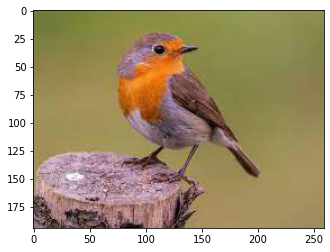

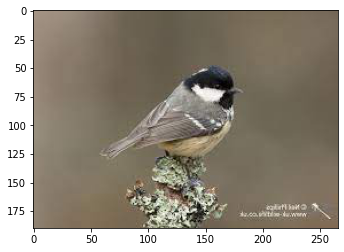

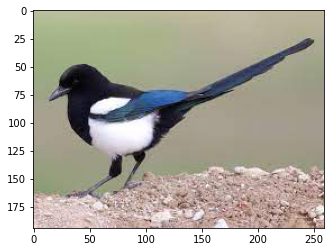

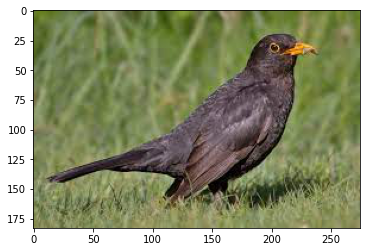

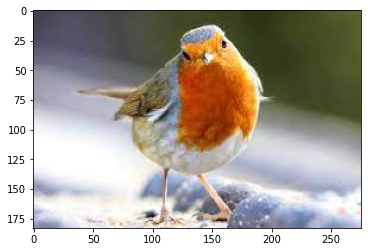

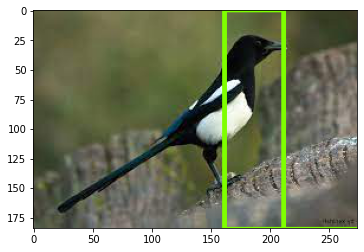

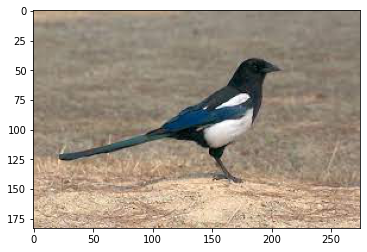

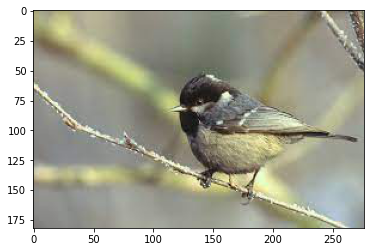

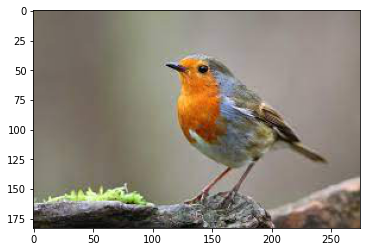

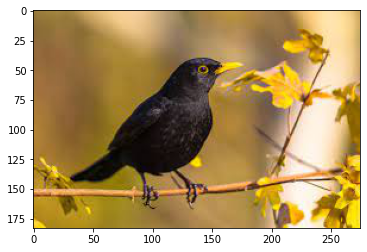

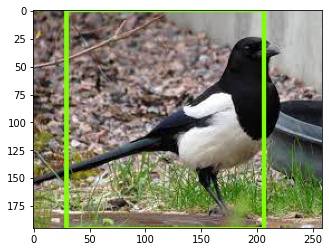

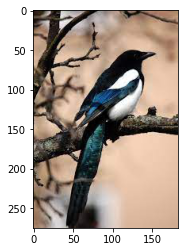

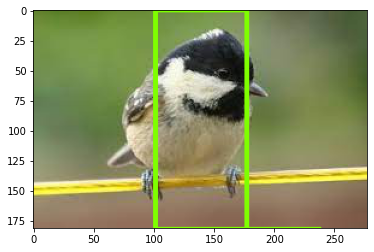

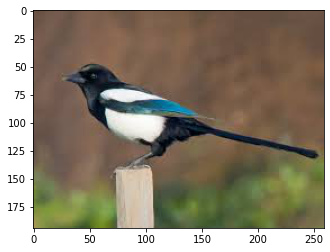

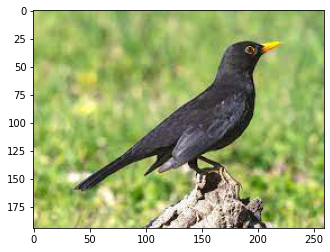

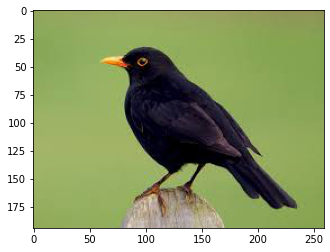

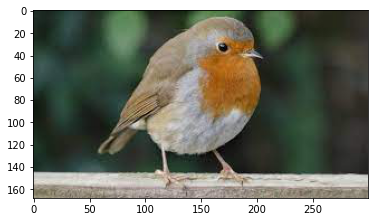

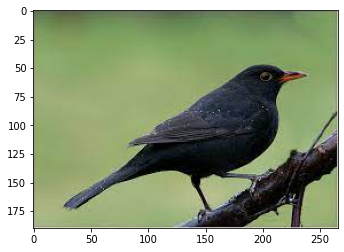

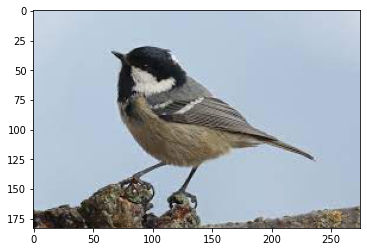

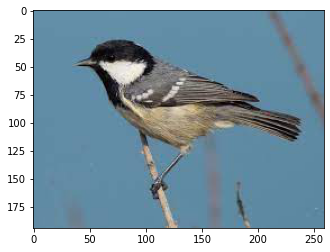

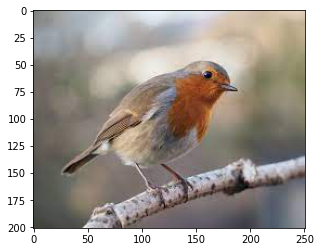

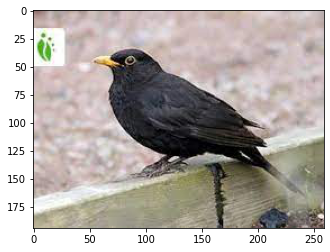

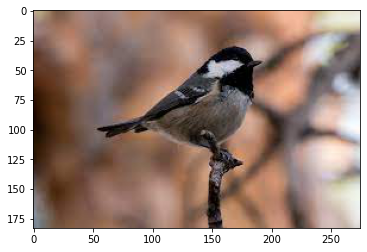

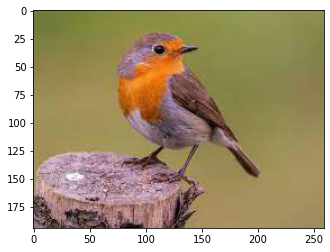

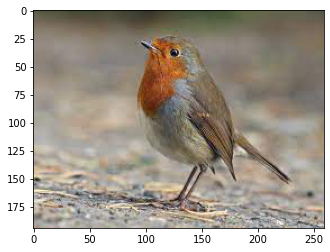

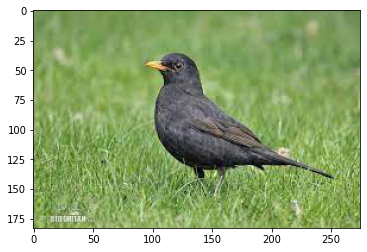

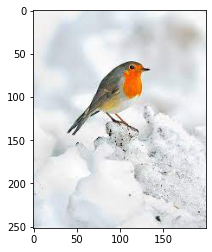

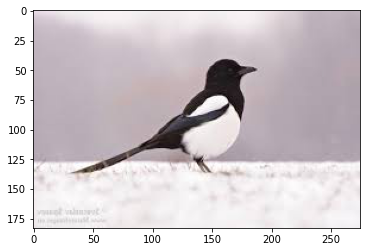

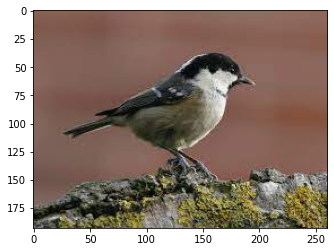

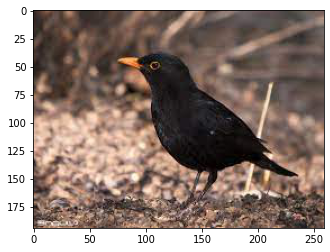

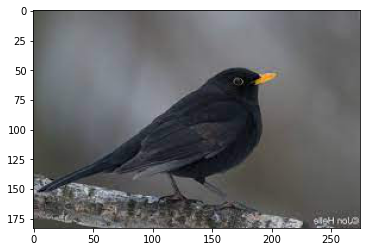

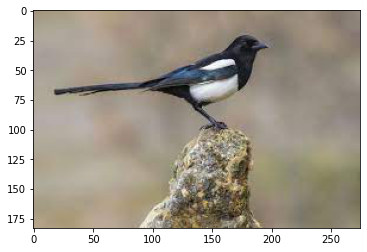

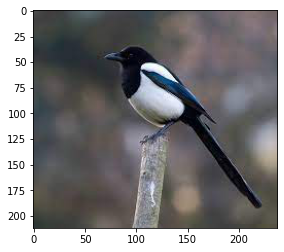

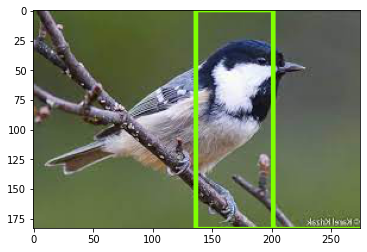

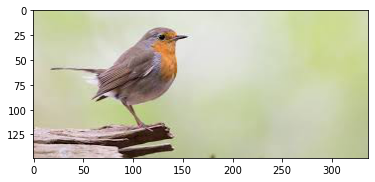

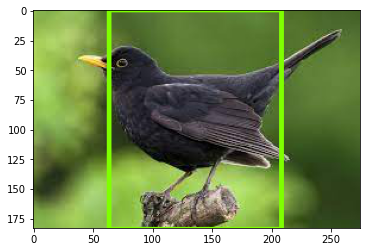

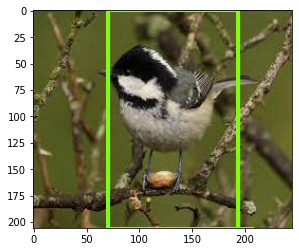

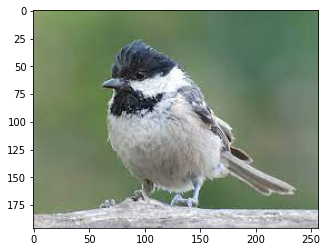

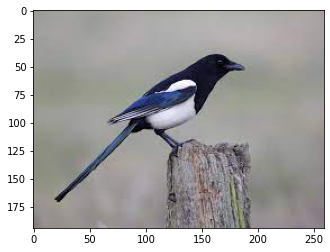

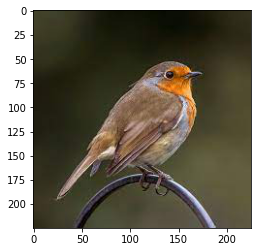

In [13]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import warnings
import os
import cv2
warnings.filterwarnings('ignore') # Suppress Matplotlib warnings
def load_image_into_numpy_array(path):
    """Load an image from file into a numpy array.
    Puts image into numpy array to feed into tensorflow graph.
    Note that by convention we put it into a numpy array with shape
    (height, width, channels), where channels=3 for RGB.
    Args:
    path: the file path to the image
    Returns:
    uint8 numpy array with shape (img_height, img_width, 3)
    """
    return np.array(Image.open(path))
for image_path in os.listdir(IMAGE_PATHS):
    image_path = os.path.join(IMAGE_PATHS, image_path)
    print('Running inference for {}... '.format(image_path), end='')
    image_np = load_image_into_numpy_array(image_path)
    # Things to try:
    # Flip horizontally
    image_np = np.fliplr(image_np).copy()
    # Convert image to grayscale
    # image_np = np.tile(
    # np.mean(image_np, 2, keepdims=True), (1, 1, 3)).astype(np.uint8)
    # The input needs to be a tensor, convert it using `tf.convert_to_tensor`
    input_tensor = tf.convert_to_tensor(image_np)
    # The model expects a batch of images, so add an axis with `tf.newaxis`.
    input_tensor = input_tensor[tf.newaxis, ...]
    # input_tensor = np.expand_dims(image_np, 0)
    detections = detect_fn(input_tensor)
    # All outputs are batches tensors.
    # Convert to numpy arrays, and take index [0] to remove the batch dimensi
    # We're only interested in the first num_detections.
    num_detections = int(detections.pop('num_detections'))
    detections = {key: value[0, :num_detections].numpy()
                    for key, value in detections.items()}
    detections['num_detections'] = num_detections
    # detection_classes should be ints. 
    detections['detection_classes'] = detections['detection_classes'].astype(np.int64)
    image_np_with_detections = image_np.copy()
        
    viz_utils.visualize_boxes_and_labels_on_image_array(
        image_np_with_detections,
        detections['detection_boxes'],
        detections['detection_classes'],
        detections['detection_scores'],
        category_index,
        use_normalized_coordinates=True,
        max_boxes_to_draw=200,
        min_score_thresh=.75,
        agnostic_mode=False)
        
    plt.figure()
    plt.imshow(image_np_with_detections)
    print('Done')
plt.show()
# sphinx_gallery_thumbnail_number = 2

In [14]:
# Exporting a Trained Inference Graph
!python exporter_main_v2.py --input_type image_tensor --pipeline_config_path ./training/TF2/training/{PATH_TO_MODEL}/pipeline.config --trained_checkpoint_dir ./training/TF2/training/{PATH_TO_MODEL}/ --output_directory ./training/TF2/training/{PATH_TO_MODEL}/saved_model/

Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.map_fn(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.map_fn(fn, elems))
W1228 15:29:08.627099 140171897852736 deprecation.py:596] From /home/msc1/anaconda3/envs/Object-Detection-API/lib/python3.8/site-packages/tensorflow/python/autograph/impl/api.py:463: calling map_fn_v2 (from tensorflow.python.ops.map_fn) with back_prop=False is deprecated and will be removed in a future version.
Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.map_fn(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.map_fn(fn, elems))
INFO:tensorflow:depth of additional conv before box predictor: 0
I1228 15:29:12.092530 140171897852736 convolutional_keras_box_predictor.py:153] depth of additional conv before box predictor: 0
Instructions for upda

## Discussion of Inference

The results of the inferencing came out quite poor. This could either mean that the performance of the model is very poor or overfitted.

I found that I got more detections when the new bird images are flipped horizontally.

I am discovering from the inferencing that the model has found a bias to always touch the top and bottom of the screen when placing it's bounding box.
This is interesting and also strange as almost all of the tagged data did not include this feature.